In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = 'Tesla.csv'
tesla_data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
tesla_data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


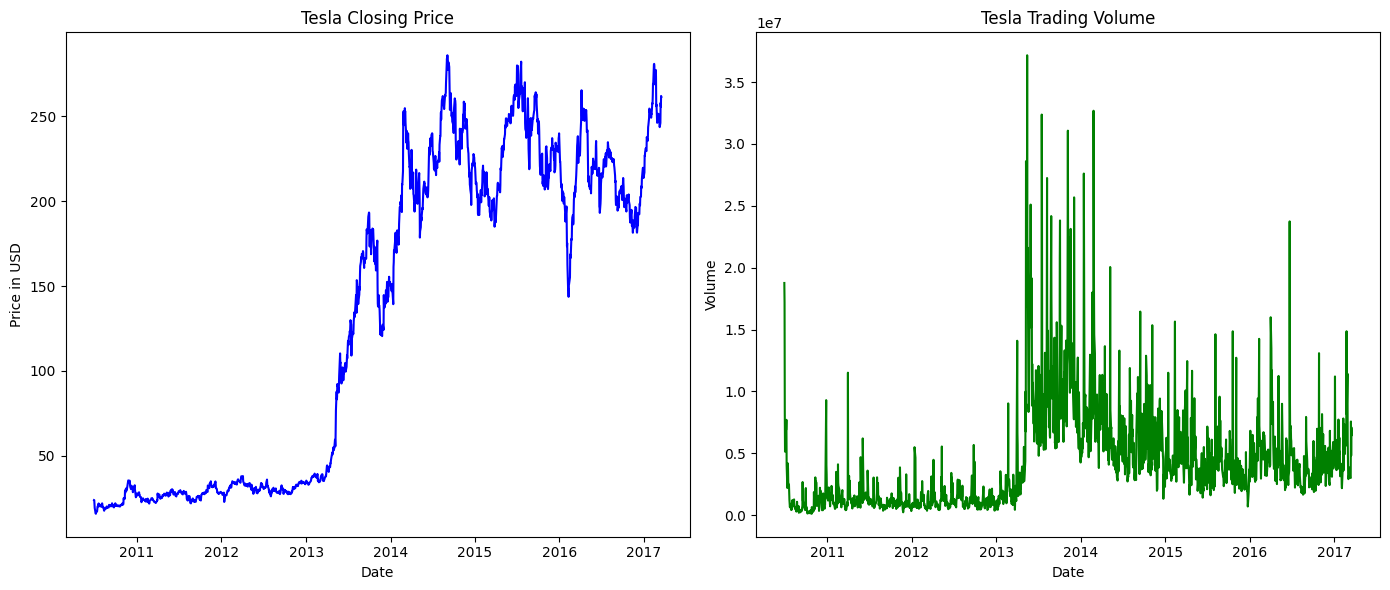

In [2]:
# Convert the 'Date' column to datetime for better plotting
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])

# Set the 'Date' column as the index
tesla_data.set_index('Date', inplace=True)

# Plotting
plt.figure(figsize=(14, 6))

# Subplot 1: Closing Price
plt.subplot(1, 2, 1)
plt.plot(tesla_data['Close'], color='blue')
plt.title('Tesla Closing Price')
plt.xlabel('Date')
plt.ylabel('Price in USD')

# Subplot 2: Volume
plt.subplot(1, 2, 2)
plt.plot(tesla_data['Volume'], color='green')
plt.title('Tesla Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.tight_layout()
plt.show()

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Calculate the 5-day moving average of the closing price
tesla_data['MA_5'] = tesla_data['Close'].rolling(window=5).mean()

# Calculate the residuals (difference between the actual closing prices and MA_5)
tesla_data['Residuals'] = tesla_data['Close'] - tesla_data['MA_5']

# Dropping NaN values that result from the rolling mean calculation
tesla_data.dropna(inplace=True)

# Normalizing the Residuals using Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))
tesla_data['Normalized_Residuals'] = scaler.fit_transform(tesla_data['Residuals'].values.reshape(-1,1))

# Display the adjusted dataframe
tesla_data[['Close', 'MA_5', 'Residuals', 'Normalized_Residuals']].head()

,Close,MA_5,Residuals,Normalized_Residuals
Date,,,,
2010-07-06,16.110001,20.998,-4.887999,0.344078
2010-07-07,15.800000,19.380,-3.580000,0.367193
2010-07-08,17.459999,18.106,-0.646001,0.419044
2010-07-09,17.400000,17.194,0.206000,0.434100
2010-07-12,17.049999,16.764,0.285999,0.435514


In [4]:
import numpy as np

def create_sequences(data, sequence_length):
    """
    Create sequences of `sequence_length` from the data.
    Each sequence is used to predict the next value.
    """
    sequences = []
    output = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:(i + sequence_length)])
        output.append(data[i + sequence_length])
    return np.array(sequences), np.array(output)

# Define the sequence length (number of days)
sequence_length = 5

# Extract the normalized residuals
data = tesla_data['Normalized_Residuals'].values

# Create sequences and corresponding outputs
X, y = create_sequences(data, sequence_length)

# Splitting the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Display the shape of the created datasets
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((1346, 5), (337, 5), (1346,), (337,))

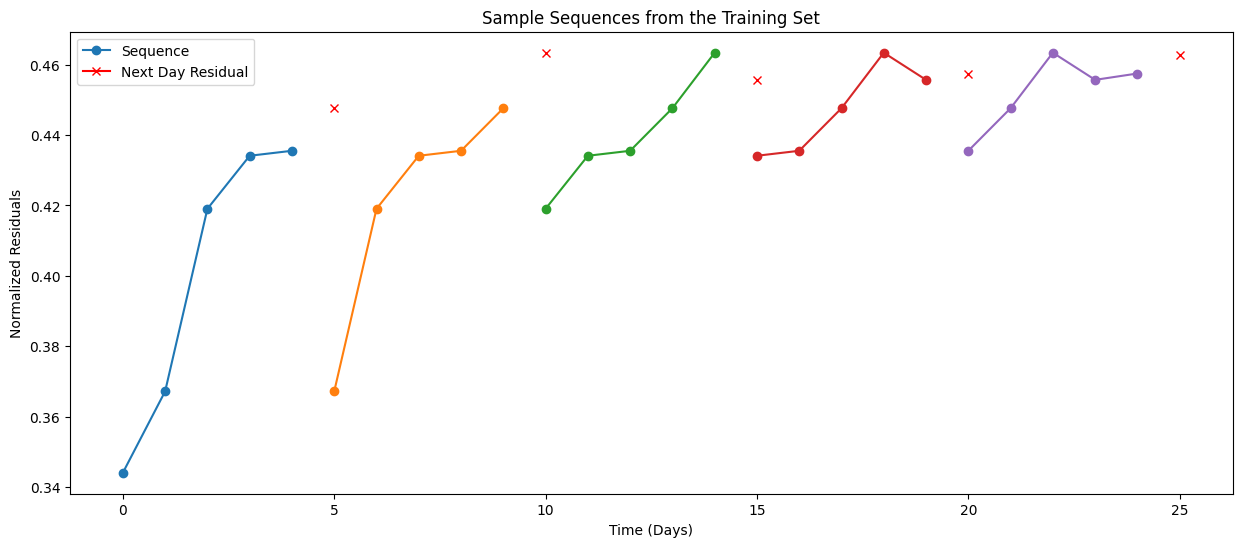

In [5]:
# Visualizing a few sequences from the training set
plt.figure(figsize=(15, 6))

# Select a few sequences to plot
num_sequences_to_plot = 5
for i in range(num_sequences_to_plot):
    # Plot each sequence
    plt.plot(range(i * sequence_length, i * sequence_length + sequence_length), X_train[i], marker='o')
    # Plot the corresponding output value
    plt.plot(i * sequence_length + sequence_length, y_train[i], marker='x', color='red')

plt.title('Sample Sequences from the Training Set')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Residuals')
plt.legend(['Sequence', 'Next Day Residual'], loc='upper left')
plt.show()

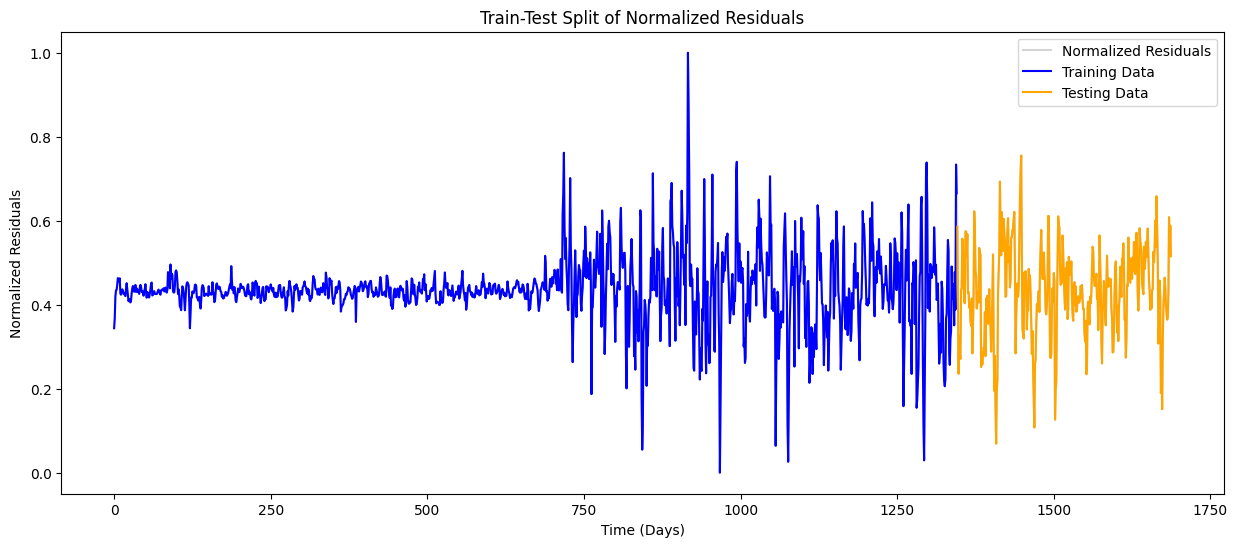

In [6]:
# Plotting the train-test split
plt.figure(figsize=(15, 6))

# Plot the entire series
plt.plot(data, label='Normalized Residuals', color='lightgray')

# Highlight the training data
plt.plot(range(train_size), data[:train_size], label='Training Data', color='blue')

# Highlight the testing data
plt.plot(range(train_size, len(data)), data[train_size:], label='Testing Data', color='orange')

plt.title('Train-Test Split of Normalized Residuals')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Residuals')
plt.legend()
plt.show()

In [7]:
import torch
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, hidden = self.rnn(x)
        x = self.fc(x[:, -1, :])  # We only care about the last output
        return x

# Model parameters
input_size = 1  # Using 1 feature (normalized residuals)
hidden_size = 64  # Size of the hidden layer
output_size = 1  # Predicting 1 value (next day's residual)

# Instantiate the model
model = SimpleRNN(input_size, hidden_size, output_size)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float().view(-1, sequence_length, 1).to(device)
y_train_tensor = torch.tensor(y_train).float().to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_losses = []
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.2017
Epoch [2/100], Loss: 0.1581
Epoch [3/100], Loss: 0.1195
Epoch [4/100], Loss: 0.0859
Epoch [5/100], Loss: 0.0575
Epoch [6/100], Loss: 0.0346
Epoch [7/100], Loss: 0.0181
Epoch [8/100], Loss: 0.0087
Epoch [9/100], Loss: 0.0070
Epoch [10/100], Loss: 0.0120
Epoch [11/100], Loss: 0.0200
Epoch [12/100], Loss: 0.0261
Epoch [13/100], Loss: 0.0277
Epoch [14/100], Loss: 0.0251
Epoch [15/100], Loss: 0.0202
Epoch [16/100], Loss: 0.0149
Epoch [17/100], Loss: 0.0105
Epoch [18/100], Loss: 0.0078
Epoch [19/100], Loss: 0.0068
Epoch [20/100], Loss: 0.0071
Epoch [21/100], Loss: 0.0082
Epoch [22/100], Loss: 0.0095
Epoch [23/100], Loss: 0.0108
Epoch [24/100], Loss: 0.0115
Epoch [25/100], Loss: 0.0118
Epoch [26/100], Loss: 0.0115
Epoch [27/100], Loss: 0.0108
Epoch [28/100], Loss: 0.0098
Epoch [29/100], Loss: 0.0088
Epoch [30/100], Loss: 0.0079
Epoch [31/100], Loss: 0.0072
Epoch [32/100], Loss: 0.0068
Epoch [33/100], Loss: 0.0067
Epoch [34/100], Loss: 0.0069
Epoch [35/100], Loss: 0

d:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1346])) that is different to the input size (torch.Size([1346, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [9]:
# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test).float().view(-1, sequence_length, 1).to(device)
y_test_tensor = torch.tensor(y_test).float().to(device)

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')


Test Loss: 0.0109


d:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([337])) that is different to the input size (torch.Size([337, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


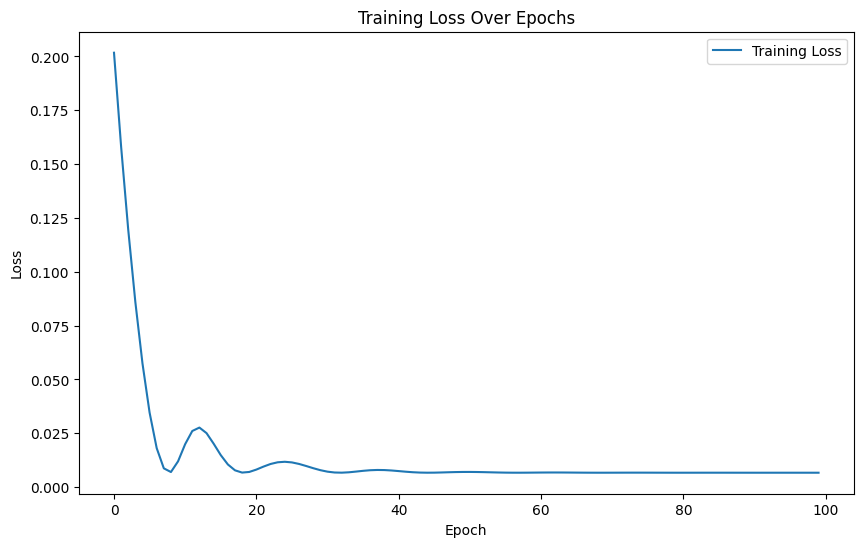

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

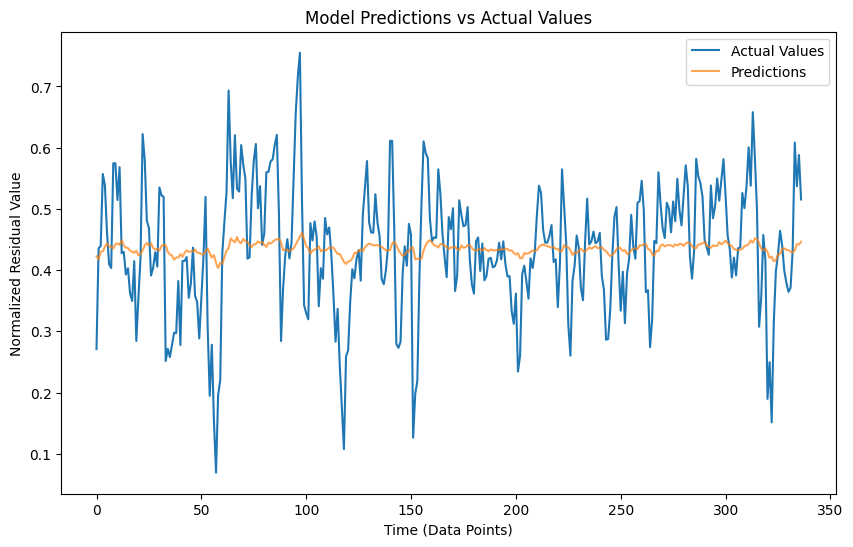

In [11]:
# Evaluate the model
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test).float().view(-1, sequence_length, 1).to(device)
    predictions = model(X_test_tensor).cpu().numpy()
    actuals = y_test

# Plot the predictions against actual values
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Values')
plt.plot(predictions, label='Predictions', alpha=0.7)
plt.title('Model Predictions vs Actual Values')
plt.xlabel('Time (Data Points)')
plt.ylabel('Normalized Residual Value')
plt.legend()
plt.show()
